In [34]:
import tracker as tr
import ect
import cv2
import matplotlib.pyplot as plt
import numpy as np

transformer = tr.FilteredTransformation(
    img_offset = 20,
    ect_offset = 0,
    radius = 200
)

loader = tr.FilepathLoader()

matcher = tr.CorrelationMatcher(
    transformer = transformer
)

template = "../sample_imgs/black_e_3.png"
image = "../sample_imgs/black_e.png"

Text(0.5, 1.0, 'image ect')

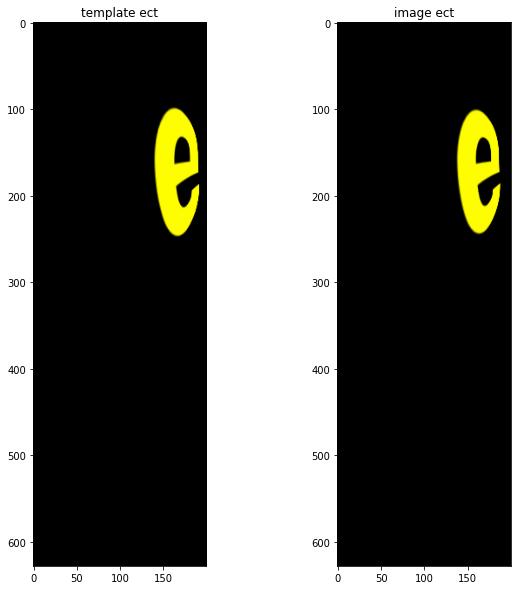

In [40]:
template_ect = loader.load(template)
image_ect = loader.load(image)

plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(ect.complex_to_hsv(template_ect))
plt.title("template ect")

plt.subplot(1, 2, 2)
plt.imshow(ect.complex_to_hsv(image_ect))
plt.title("image ect")

Text(0.5, 1.0, 'image ect')

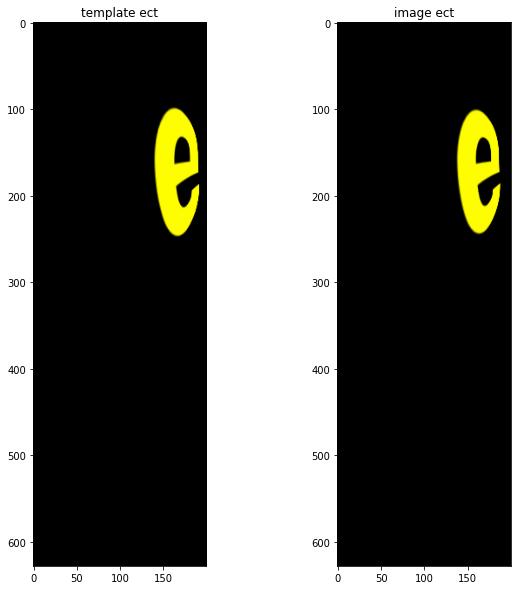

In [41]:

# template_ect = transformer.transform(template_ect)

# image_ect = transformer.transform(image_ect)

sidelobe = ect.sidelobe(image_ect.shape[:2], offset=40)

# image_ect = image_ect * sidelobe
# template_ect = template_ect * sidelobe

plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(ect.complex_to_hsv(template_ect))
plt.title("template ect")

plt.subplot(1, 2, 2)
plt.imshow(ect.complex_to_hsv(image_ect))
plt.title("image ect")

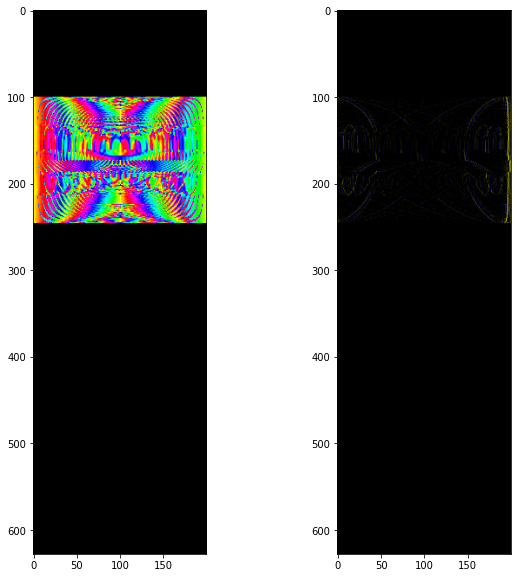

In [43]:
image_tr = np.fft.fft2(image_ect)
template_tr = np.fft.fft2(template_ect)

# thresh = 0.2
# template_abs = ect.norm_minmax(np.abs(template_tr), 0, 1, dtype=np.float64)

# bp_filter = np.zeros_like(template_abs)
# bp_filter[template_abs > thresh] = 1

# xcorr = image_ect * np.conj(template_ect)
# xcorr = np.conj(image_tr) * template_tr
xcorr = image_tr * np.conj(template_tr)
xcorr_norm = xcorr/(np.abs(xcorr) + 1e-6) #* bp_filter

# xcorr_inv = ect.ifect(
#     xcorr,
#     img_offset=transformer.img_offset,
#     ect_offset=transformer.ect_offset
# )

xcorr_inv = np.fft.ifft2(xcorr_norm)


plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(ect.complex_to_hsv(xcorr_norm))

plt.subplot(1, 2, 2)
plt.imshow(ect.complex_to_hsv(xcorr_inv))

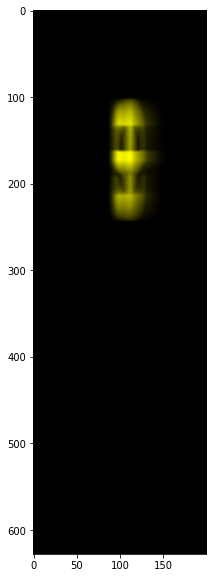

In [44]:
match_result = np.abs(transformer.invert(xcorr))

plt.figure(figsize=(10, 10))
plt.imshow(ect.complex_to_hsv(match_result))


In [27]:
idx = np.argmax(np.abs(match_result))
p, r = np.unravel_index(idx, match_result.shape[:2])

print(f"{p=}, {r=}, {match_result[p, r, 0]=:.2f}")

p=475, r=145, match_result[p, r, 0]=48513341435821112.00
